In [1]:
%matplotlib inline

In [2]:
from matplotlib import pyplot as plt
import numpy as np

In [6]:
def sigmoid(x):
    return 1.0 / (1.0 + np.exp(-x))
def sigmoidp(x):
    return x * (1.0 - x)

class CNN(object):
    def __init__(self, ks, lr=0.01):
        self.ks = ks
        self.W = None
        self.b = None
        self.lr = lr
        
    def run(self, img, t):
        self.ff(img)
        dcdh, y, c = self.cost(self.hs[-1], t)
        self.bp(dcdh)
        
        return y, c
        
    def ff(self, img):
        hs = [img]
        h = img
        for k in self.ks:
            hout = self.conv(h, k, 1)
            h = hout
            hs.append(h)
            
        self.hs = np.asarray(hs)
        
        return self.hs
    
    def bp(self, lastd):
        d = lastd
        ds = [lastd]
        kgs = []
        for i in reversed(xrange(len(self.hs) - 1)):
            kg, d = self.convbp(self.hs[i], self.ks[i], 1, d)
            ds.insert(0, d)
            kgs.append(kg)
            
        for i, kg in enumerate(kgs):
            self.ks[i] -= self.lr * kg
        
        self.kgs = np.asarray(kgs)
        self.ds = np.asarray(ds)
        
        return self.kgs, self.ds
    
    def cost(self, h, t):
        # make h flat
        hflat = h.reshape((1, h.shape[0] * h.shape[1]))
        
        if self.W is None:
            self.W = np.random.random_sample((hflat.shape[1], t.shape[1])) * 2.0 - 1.0
            self.b = np.random.random_sample((1, t.shape[1])) * 2.0 - 1.0
            print 'Init W', self.W.shape, 'and b', self.b.shape
            
        s = hflat.dot(self.W) + self.b
        y = sigmoid(s)
        
        c = .5 * np.sum(np.square(y - t))
        
        dcdy = (y - t).T
        dyds = sigmoidp(y).T
        dsdh = self.W
        
        gW = np.multiply(hflat.T, (dcdy * dyds).T)
        gb = (dcdy * dyds).T
        
        #update weights
        self.W -= gW * self.lr
        self.b -= gb * self.lr
        
        dcdh = dsdh.dot(dyds * dcdy)
        
        dcdh = dcdh.reshape(h.shape)
        
        return dcdh, np.asarray(y), c
    
    def conv(self, img, kernel, s):
        idim = img.shape[0]
        ichan = img.shape[2]
        kdim = kernel.shape[0]
        kchan = kernel.shape[2]
        
        hdim = (idim - kdim) / s + 1

        h = np.zeros((hdim, hdim, ichan * kchan))
                
        for ic in xrange(ichan):
            for kc in xrange(kchan):
                hindex = ic * kchan + kc
                for r in xrange(hdim):
                    for c in xrange(hdim):
                        h[r,c,hindex] = sigmoid(np.sum(img[r*s:r*s+kdim, c*s:c*s+kdim, ic] * kernel[:,:,kc]))

        return h

    def convbp(self, img, kernel, s, delta):
        idim = img.shape[0]
        ichan = img.shape[2]

        kdim = kernel.shape[0]
        kchan = kernel.shape[2]

        ddim = delta.shape[0]
        dchan = delta.shape[2]
        
        # bring deltas back to img and calc gradients
        imgd = np.zeros_like(img)
        kg = np.zeros_like(kernel)
        
        delta = sigmoidp(delta) * delta
        
        for ic in xrange(ichan):
            for kc in xrange(kchan):
                index = ic * kchan + kc
                for r in xrange(ddim):
                    for c in xrange(ddim):
                        imgd[r*s:r*s+kdim,c*s:c*s+kdim, ic] += delta[r,c,index] * kernel[:,:,kc]
                        kg[:,:,kc] += delta[r,c,index] * img[r*s:r*s+kdim,c*s:c*s+kdim, ic]

        return kg, imgd
    
column = 1
cnt = 1
def gstart(count, size=(12,12)):
    plt.figure(figsize=size)
    global column, cnt
    column = 1
    cnt = count
    
def g(mat, title=None):
    global column
    plt.subplot(1, cnt, column)
    plt.axis('off')
    if title:
        plt.title(title + str(mat.shape))
    plt.imshow(mat, interpolation='nearest', cmap=plt.cm.gray, vmin=-1, vmax=1)
    column += 1

In [7]:
img = plt.imread('imgs/witch.png')[240:300, 240:300, 1]
img = img.reshape((img.shape[0], img.shape[1], 1))
layers = 4

t = np.ones((1, 4))

ks = np.random.random_sample((layers,3,3,1)) * 2.0 - 1.0
myCNN = CNN(ks, 0.01)

In [53]:
y, c = myCNN.run(img, t)
print 'y', y[0]
print 'cost', c

y [  9.37005715e-01   9.32793887e-01   9.99998585e-01   2.53185836e-06]
cost 0.504239938903


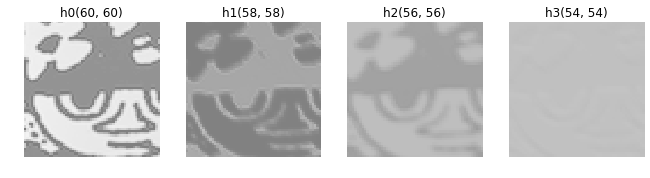

In [54]:
gstart(layers+1, (14, 14))
for i in xrange(layers):
    g(myCNN.hs[i][:,:,0], 'h%d'%i)

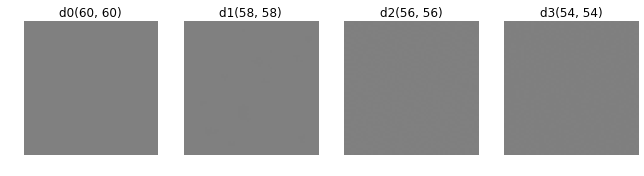

In [55]:
gstart(layers, (11, 11))
for i in xrange(layers):
    g(myCNN.ds[i][:,:,0], 'd%d'%i)